Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [2]:
import random
import numpy as np
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from datasets import UCIHAR
import matplotlib.pyplot as plt
from utils import imputation_rmse, mean_impute, classify
from models import TSImputer, GRUPlusFC
from sklearn.metrics import f1_score


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [3]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.2

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training/testing
batch_size = 128

# Number of training epochs for imputation model
num_epochs = 50

# Number of training epochs for the classifier
clf_epochs = 100

# Learning rate for optimizers
lr = 0.005

# Generator MSELoss multiplier
alpha = 100

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



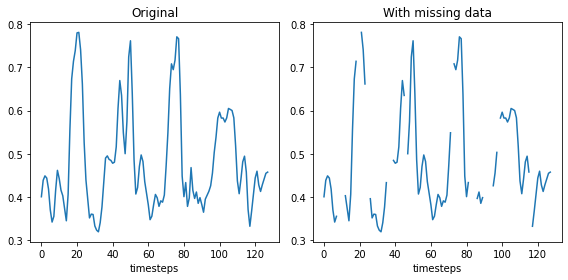

In [4]:
# Create the datasets
ucihar_observed = UCIHAR(root_dir=root, download=True)
ucihar_miss = UCIHAR(root_dir=root, miss_rate=miss_rate)
ucihar_test = UCIHAR(root_dir=root, train=False)

# Create the dataloaders
dataloader = DataLoader(ucihar_observed, batch_size=batch_size, num_workers=workers)
dataloader_test = DataLoader(ucihar_test, batch_size=batch_size, num_workers=workers)
dataloader_miss = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples, n_timesteps, n_features = ucihar_observed.data.shape
n_classes = len(ucihar_observed.labels)

# Plot some signal before/after amputation
signal_id = 0
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar_observed.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
axes[0].set_xlabel("timesteps")
axes[0].set_title("Original")
axes[1].set_title("With missing data")
axes[1].set_xlabel("timesteps")

fig.tight_layout()

Model
--------------

The GAN model is using a GRU for both the generator and the discriminator.

In [5]:
gan_imputer = TSImputer(
    sequence_length=n_timesteps,
    input_size=n_features,
    hidden_size=hz,
    alpha=alpha,
    lr=lr
)

Training
--------------

In [6]:
gan_imputer.fit(
    dataloader_miss, 
    ucihar_observed.data,
    ucihar_miss.data,
    num_epochs=num_epochs,
)

[0/50][0/58]	LossD: 0.690446	LossG_rec: 0.011231	LossG_adv: 0.123605
[0/50][50/58]	LossD: 0.484161	LossG_rec: 0.009832	LossG_adv: 0.037879
[1/50][0/58]	LossD: 0.483797	LossG_rec: 0.005957	LossG_adv: 0.039078
[1/50][50/58]	LossD: 0.482137	LossG_rec: 0.005081	LossG_adv: 0.039201
[2/50][0/58]	LossD: 0.481441	LossG_rec: 0.002860	LossG_adv: 0.039554
[2/50][50/58]	LossD: 0.472380	LossG_rec: 0.004637	LossG_adv: 0.042096
[3/50][0/58]	LossD: 0.471886	LossG_rec: 0.002648	LossG_adv: 0.043282
[3/50][50/58]	LossD: 0.464501	LossG_rec: 0.004009	LossG_adv: 0.046604
[4/50][0/58]	LossD: 0.463361	LossG_rec: 0.002418	LossG_adv: 0.046418
[4/50][50/58]	LossD: 0.466753	LossG_rec: 0.003157	LossG_adv: 0.064644
[5/50][0/58]	LossD: 0.470122	LossG_rec: 0.002132	LossG_adv: 0.033048
[5/50][50/58]	LossD: 0.452181	LossG_rec: 0.002436	LossG_adv: 0.051171
[6/50][0/58]	LossD: 0.454120	LossG_rec: 0.001753	LossG_adv: 0.046318
[6/50][50/58]	LossD: 0.442481	LossG_rec: 0.001761	LossG_adv: 0.058328
[7/50][0/58]	LossD: 0.43882

## Results


### Loss versus training iteration

Below is a plot of D & G’s losses versus training iterations.

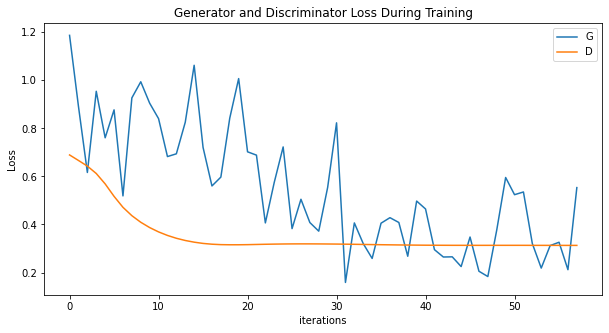

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gan_imputer.lossesG, label="G")
plt.plot(gan_imputer.lossesD, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### RMSE versus Epoch

Below is a plot of the RMSE during training and comparaison with mean imputation RMSE

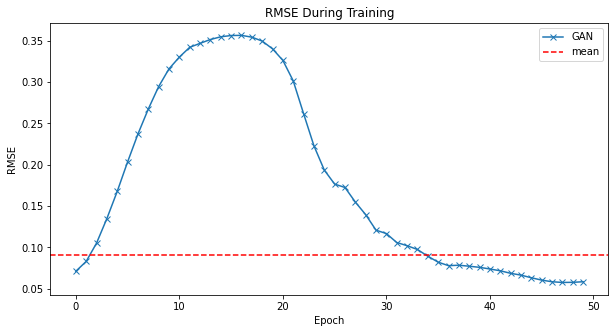

Minimum RMSE of 0.0576 achieved around epoch 48


In [7]:
# Compute the RMSE of mean imputation
mean_imputed = mean_impute(ucihar_miss.data)
mask = ~torch.isnan(ucihar_miss.data)
mean_rmse = imputation_rmse(ucihar_observed.data.numpy(), mean_imputed.numpy(), mask.numpy())

# Plot result
plt.figure(figsize=(10,5))
plt.title("RMSE During Training")
plt.plot(np.arange(num_epochs), gan_imputer.rmse_vals, marker='x', label="GAN")
plt.axhline(y=mean_rmse, color='r', linestyle='--', label="mean")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.savefig(f"rmse.png")
plt.show()

from operator import itemgetter
argmin_rmse, min_rmse = min(enumerate(gan_imputer.rmse_vals), key=itemgetter(1))
print(
    f"Minimum RMSE of {min_rmse:.4f} "
    f"achieved around epoch {(argmin_rmse + 1)}"
)


### Imputation

We now impute the data and save it in `x_imputed`.

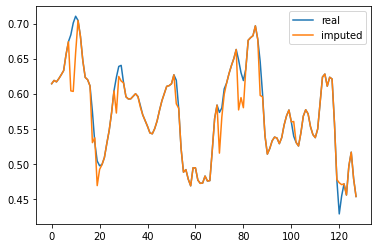

In [7]:
gan_imputed = gan_imputer.impute(x_miss=ucihar_miss.data)

# Plot some signal before/after imputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
plt.plot(ucihar_observed.data[sample_id, :, signal_id], label="real")
plt.plot(gan_imputed[sample_id, :, signal_id], label="imputed")
plt.legend()
plt.show()

### Performance Comparison for Classification Task

We compare the test accuracy obtained by training a classifier on the complete
dataset, mean imputation and our GAN-based imputation.

For the classifier, we use a simple GRU followed by a fully connected layer

#### Training the classifier on the GAN-imputed dataset

First, we train the classifier on the data imputed with GAN `gan_imputed`

In [ ]:
# Classifier model
clf = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)


# Create loader for imputed data
dataloader_imp = DataLoader(
    TensorDataset(gan_imputed, ucihar_observed.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader_imp,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

Epoch [0/100]	 Loss: 1.637055	 Train Accuracy: 0.2782	Test Accuracy: 0.4204
Epoch [1/100]	 Loss: 1.469827	 Train Accuracy: 0.3415	Test Accuracy: 0.4096
Epoch [2/100]	 Loss: 1.323790	 Train Accuracy: 0.4014	Test Accuracy: 0.3577
Epoch [3/100]	 Loss: 1.288351	 Train Accuracy: 0.4234	Test Accuracy: 0.4153
Epoch [4/100]	 Loss: 1.225090	 Train Accuracy: 0.4714	Test Accuracy: 0.5908
Epoch [5/100]	 Loss: 0.887090	 Train Accuracy: 0.5900	Test Accuracy: 0.6685
Epoch [6/100]	 Loss: 0.748302	 Train Accuracy: 0.6639	Test Accuracy: 0.7336
Epoch [7/100]	 Loss: 0.637136	 Train Accuracy: 0.7097	Test Accuracy: 0.7452
Epoch [8/100]	 Loss: 0.576277	 Train Accuracy: 0.7422	Test Accuracy: 0.7499
Epoch [9/100]	 Loss: 0.549018	 Train Accuracy: 0.7510	Test Accuracy: 0.7869
Epoch [10/100]	 Loss: 2.242990	 Train Accuracy: 0.3252	Test Accuracy: 0.3390
Epoch [11/100]	 Loss: 1.472614	 Train Accuracy: 0.3985	Test Accuracy: 0.5151
Epoch [12/100]	 Loss: 1.384568	 Train Accuracy: 0.3704	Test Accuracy: 0.3892
Epoch [13

#### Training the classifier on the original dataset 


In [22]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

Epoch [0/1]	 Loss: 1.548661	 Train Accuracy: 0.3789	Test Accuracy: 0.3451
Best Accuracy obtained: 0.3451


#### Training the classifier on a mean-imputed dataset

Finally, for the sake of comparaison we also train the classifier on the dataset that is imputed using the **mean** method.

In [10]:
# Classifier model
clf = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)

# Create loader for imputed data
dataloader_mean = DataLoader(
    TensorDataset(mean_imputed, ucihar_observed.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader_mean,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

Epoch [0/100]	 Loss: 1.564198	 Train Accuracy: 0.3236	Test Accuracy: 0.4194
Epoch [1/100]	 Loss: 1.894259	 Train Accuracy: 0.2765	Test Accuracy: 0.3383
Epoch [2/100]	 Loss: 1.461672	 Train Accuracy: 0.3598	Test Accuracy: 0.3502
Epoch [3/100]	 Loss: 1.398783	 Train Accuracy: 0.3768	Test Accuracy: 0.3448
Epoch [4/100]	 Loss: 1.323542	 Train Accuracy: 0.4030	Test Accuracy: 0.3020
Epoch [5/100]	 Loss: 1.275392	 Train Accuracy: 0.4373	Test Accuracy: 0.4296
Epoch [6/100]	 Loss: 1.089660	 Train Accuracy: 0.5275	Test Accuracy: 0.6339
Epoch [7/100]	 Loss: 0.807933	 Train Accuracy: 0.6566	Test Accuracy: 0.7265
Epoch [8/100]	 Loss: 0.721057	 Train Accuracy: 0.6810	Test Accuracy: 0.7710
Epoch [9/100]	 Loss: 0.624233	 Train Accuracy: 0.7250	Test Accuracy: 0.7458
Epoch [10/100]	 Loss: 0.610294	 Train Accuracy: 0.7218	Test Accuracy: 0.7845
Epoch [11/100]	 Loss: 0.524242	 Train Accuracy: 0.7733	Test Accuracy: 0.7998
Epoch [12/100]	 Loss: 0.513135	 Train Accuracy: 0.7701	Test Accuracy: 0.8127
Epoch [13